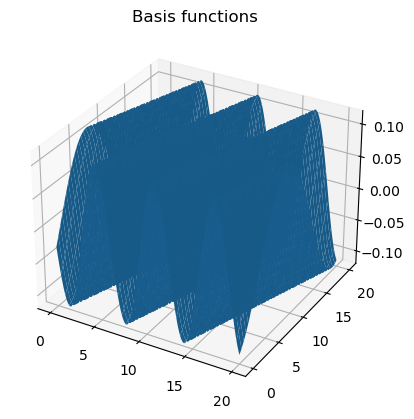

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib import cm

def lerp(a, b, t):
    return a * (1-t) + b * t

def step(edge, x):
    return np.heaviside(x-edge, 0)

def smoothstep(edge0, edge1, x):
    t = np.clip((x - edge0) / (edge1 - edge0), 0.0, 1.0)
    return t * t * (3 - 2*t)

def smootherstep(edge0, edge1, x):
    # Scale, and clamp x to 0..1 range
    t = np.clip((x - edge0) / (edge1 - edge0), 0.0, 1.0)

    return t * t * t * (t * (6.0 * t - 15.0) + 10.0)


# The standard set of weight-space GP basis functions
class GPBasis():
    def __init__(self, l, d):
        self.thetas = np.random.normal(scale=1, size=(l,d)) # Spectral density of the squared exponential is the normal distribution
        self.taus = np.random.uniform(size=l) * 2 * np.pi # Uniformly distributed as in the paper

    def phi(self, x):
        return np.sqrt(2/self.thetas.shape[0]) * np.cos( np.dot(x,self.thetas.T) + self.taus)
    
    def size(self):
        return self.thetas.shape[0]



#Just another non-standard set of basis functions
class SinWaveBasis():
    def __init__(self, l):
        self.freq = np.linspace(0, 5, l)
        self.phase = np.linspace(0, np.pi*2, l)
        self.amplitude = 1/(2**np.linspace(0, 10, l))

    def phi(self, x):
        return np.sqrt(2/len(self.freq)) * np.sin(self.freq[None,:] * x[...,None] + self.phase)
    
    def size(self):
        return self.freq.shape[0]

# My interpretation of what "Perlin noise basis functions" would look like
# WJ: what's currently here is actually a combination of gradient noise (Perlin) and value noise
class PerlinNoiseBasis():
    def cell(self, x):
        interp = (x - self.x_range[0]) / (self.x_range[1] - self.x_range[0])
        cell_pos = interp * (self.random_numbers.shape[1] - 1)
        return np.array(np.floor(cell_pos), dtype=int), cell_pos - np.floor(cell_pos)

    def perlin(self, x, noise_idx):
        cell_x, frac_x = self.cell(x)
        cell_x = (cell_x) % self.random_numbers.shape[1]
        ncell_x = (cell_x+1) % self.random_numbers.shape[1]
        # this controls how much value noise is mixed in
        # setting this to 0 makes this true Perlin (gradient) noise
        value_amount = 0
        a = value_amount*self.random_numbers[noise_idx, cell_x, 0]
        b = value_amount*self.random_numbers[noise_idx, ncell_x, 0]

        # this controls how much gradient noise should be mixed it.
        # setting this to 0 (and value_amount to 1) creates value noise
        gradient_amount = 1
        a_x = gradient_amount*self.random_numbers[noise_idx, cell_x, 1]
        b_x = gradient_amount*self.random_numbers[noise_idx, ncell_x, 1]

        # perform linear extrapolation from neighboring grid locations
        a += a_x*frac_x
        b += b_x*(frac_x-1.0)

        # blend the extrapolated values
        # weight_b = step(0.5, frac_x)              # constant
        # weight_b = frac_x                         # linear
        weight_b = smootherstep(0.0,1.0,frac_x)     # cubic

        return a * (1-weight_b) + b * weight_b
    
    def size(self):
        return self.freq.shape[0] * self.random_numbers.shape[0]

    def __init__(self, n_octaves, n_noises, x_range=(0,20), grid_size=20):
        np.random.seed(51)
        self.x_range = x_range
        self.random_numbers = np.random.uniform(low=-1, high=1, size=(n_noises, grid_size+1, 2))
        self.freq = 2**np.linspace(0, n_octaves, n_octaves, False)
        # the division factor here just ensures that the largest scale octave has 4 wiggles over the x_range
        self.freq = self.freq / (x_range[1]-x_range[0]) * 4
        self.amplitude = 0.5**(np.linspace(0, n_octaves, n_octaves, False) + 1)
        self.phase = x_range[0] + np.random.uniform(size=n_octaves*n_noises) * (x_range[1] - x_range[0])


    def phi(self, x):
        noise_loc = self.freq[None,:] * (x[...,None])
        noise_scale = self.amplitude / np.sum(self.amplitude)
        noise_idx = np.tile(np.arange(0, self.random_numbers.shape[0]), noise_loc.shape)
        noise_loc = np.repeat(noise_loc, self.random_numbers.shape[0], axis=-1)
        noise_scale = np.repeat(noise_scale, self.random_numbers.shape[0], axis=-1)
        noise_idx = noise_idx.reshape(noise_loc.shape)

        return self.perlin(noise_loc + self.phase[None,...], noise_idx) * noise_scale



# Evaluate Eq. (6)
def evaluate_basis(x, basis, weights):
    return np.sum(weights[None,...]*basis.phi(x), axis=-1)

# Compute mean and covariance of posterior weight distribution (Eq. (7))
def condition(X, y, basis, sigma):
    P = basis.phi(X)
    PtP = P.transpose() @ P
    cm_inv = np.linalg.inv(PtP + sigma**2 * np.identity(PtP.shape[0]))

    mu = cm_inv @ (P.transpose() @ y[...,None])
    Sigma = cm_inv * sigma**2
    return mu.flatten(), Sigma

# Number of basis functions
x_range = (0,20)
y_range = (0,20)

# Setup basis function
# basis = SinWaveBasis(l)
#basis = PerlinNoiseBasis(5, 10, x_range=x_range, grid_size=x_range[1])
basis = GPBasis(150,2)

# Evaluation points for plotting
xcs = np.linspace(x_range[0], x_range[1], 300)
ycs = np.linspace(y_range[0], y_range[1], 300)

xxs, yys = np.meshgrid(xcs, ycs)

xs = np.stack((xxs,yys), axis=-1).reshape(-1,2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.set_title("Basis functions")
ax.plot_surface(xxs, yys, basis.phi(xs)[:,0].reshape(len(xcs),len(ycs)))
# plt.plot(xs, np.zeros(2000))
# plt.plot(ints, basis.phi(ints), 'o')
#ax.xticks(np.linspace(x_range[0], x_range[1], x_range[1]+1))
#ax.yticks(np.linspace(y_range[0], y_range[1], y_range[1]+1))
# plt.ylim(-1,1)
plt.show()


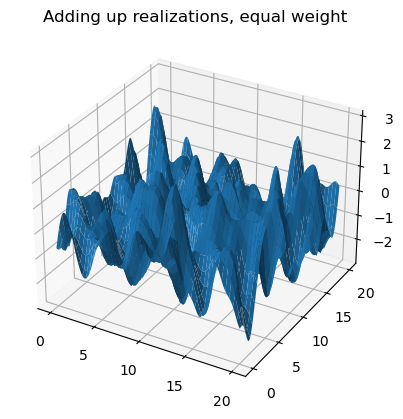

In [32]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.set_title("Adding up realizations, equal weight")
real = evaluate_basis(xs,basis,np.ones(basis.size()))

ax.plot_surface(xxs, yys, real.reshape(len(xcs),len(ycs)))
plt.show()


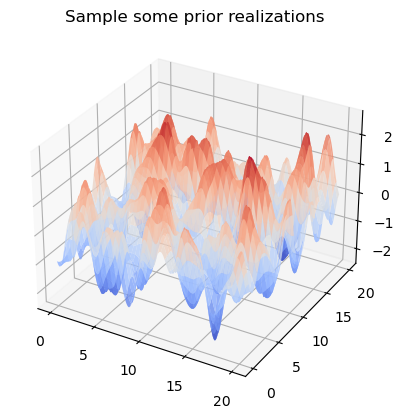

In [33]:

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_title("Sample some prior realizations")

weights = np.random.normal(size=(1,basis.size()))
for w in weights:
    real = evaluate_basis(xs,basis,w)
    ax.plot_surface(xxs, yys, real.reshape(len(xcs),len(ycs)),alpha=0.8,cmap=cm.coolwarm, linewidth=0)

plt.show()


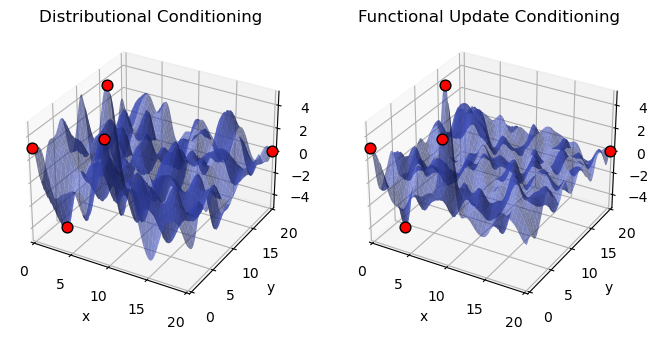

In [34]:
from matplotlib.animation import FuncAnimation

def cov(x,y):
    d = x-y
    return np.exp(-np.sum(d**2, axis=-1))

def gen_cov_input(A, B):
    apsx, bpsx = np.meshgrid(A[:,0], B[:,0])
    apsy, bpsy = np.meshgrid(A[:,1], B[:,1])
    aps = np.dstack((apsx, apsy)).reshape(B.shape[0], A.shape[0], -1).transpose(1,0,2)
    bps = np.dstack((bpsx, bpsy)).reshape(B.shape[0], A.shape[0], -1).transpose(1,0,2)
    return aps, bps

def apply_functional_update(x, weights, basis, cov, X, y, sigma):
    residual = y - evaluate_basis(X, basis, weights)

    cov_mat = cov(*gen_cov_input(X,X)) + sigma**2 * np.identity(X.shape[0])

    v = np.linalg.solve(cov_mat, residual)

    cov_xX = cov(*gen_cov_input(x,X))

    return evaluate_basis(x, basis, weights) + np.sum(v * cov_xX, axis=-1)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d", "computed_zorder":False}, figsize=(8,4))

num_iters = 20
colors = cm.coolwarm(np.linspace(0, 1, num_iters))

def animate(i):
    # Condition locations and values
    cond_xc = np.array([i*0.2, 3, 10, 0, 20])
    cond_yc = np.array([0, 2, 0, 15, 20])
    cond_v = np.array([3+i*0.1, -4, 10-i*0.4, -1, 0])

    #cond_xc = np.array([10, 0])
    #cond_yc = np.array([0, 0])
    #cond_v = np.array([5, -5])

    cond_x = np.stack((cond_xc, cond_yc), axis=-1)

    # Compute posterior weight mean and covariances
    cond = condition(cond_x, cond_v, basis, 0.01)

    # Sample and plot 1 realization
    weights_conditioned = np.atleast_2d(multivariate_normal(mean=cond[0], cov=cond[1], allow_singular=True).rvs(size=1,random_state=1))
    weights_unconditioned = np.atleast_2d(multivariate_normal(mean=np.zeros(basis.size()), cov=np.identity(basis.size())).rvs(size=1,random_state=1))

    for ax in axs:
        ax.clear()

    axs[0].set_title("Distributional Conditioning")
    axs[1].set_title("Functional Update Conditioning")

    for wi in range(weights_conditioned.shape[0]):
        real_distributional = evaluate_basis(xs,basis,weights_conditioned[wi])
        real_functional = apply_functional_update(xs, weights_unconditioned[wi], basis, cov, cond_x, cond_v, 0.01)
        axs[0].plot_surface(xxs, yys, real_distributional.reshape(len(xcs),len(ycs)),color=colors[i], linewidth=0,alpha=0.6)
        axs[1].plot_surface(xxs, yys, real_functional.reshape(len(xcs),len(ycs)),color=colors[i], linewidth=0,alpha=0.6)

    axs[0].scatter(cond_xc, cond_yc, cond_v, color="red",edgecolors='black',s=60, depthshade=False)
    axs[1].scatter(cond_xc, cond_yc, cond_v, color="red",edgecolors='black',s=60, depthshade=False)

    # Draw conditioning points
    for ax in axs:
        ax.set_xlim(0, 20)
        ax.set_ylim(0, 20)
        ax.set_zlim(-5, 5)
        ax.set_xlabel("x")
        ax.set_ylabel("y")

ani = FuncAnimation(fig, animate, interval=4, frames=num_iters)
ani.save('test.gif')

#ax.set_title("Sampled posterior realizations")
#for i in range(num_iters):
#    animate(i)
#plt.show()

In [ ]:
import math

import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseEvent
from matplotlib import cm
from matplotlib.widgets import Slider, Button
%matplotlib qt

class DraggablePlotExample(object):
    u""" An example of plot with draggable markers """

    def __init__(self):
        self._figure, self._axes, self._line_dist, self._line_func, self._scatter = None, None, None, None, None
        self._dragging_point = None
        self._points = {}
        self._colors = cm.coolwarm(np.linspace(0, 1, num_iters))

        self._init_plot()

    def _init_plot(self):
        self._figure = plt.figure("Conditioning Editor")
        axes = plt.subplot(1, 1, 1)
        axes.set_xlim(0, 20)
        axes.set_ylim(-5.5, 5.5)
        axes.grid(which="both")
        self._axes = axes

        self._figure.subplots_adjust(bottom=0.25)

        self._figure.canvas.mpl_connect('button_press_event', self._on_click)
        self._figure.canvas.mpl_connect('button_release_event', self._on_release)
        self._figure.canvas.mpl_connect('motion_notify_event', self._on_motion)
        self._axsigma = self._figure.add_axes([0.1, 0.1, 0.8, 0.03])
        self._sigma_slider = Slider(
            ax=self._axsigma,
            label='$\\sigma$',
            valmin=0.0001,
            valmax=1,
            valinit=0.1,
        )

        self._sigma_slider.on_changed(lambda _: self._update_plot())

        plt.show()

    def _update_plot(self):
        if not self._points:
            self._line_dist.set_data([], [])
            self._line_func.set_data([], [])
        else:
            # Condition locations and values
            x, y = zip(*sorted(self._points.items()))

            cond_x = np.array(x)
            cond_y = np.array(y)

            # Compute posterior weight mean and covariances
            cond = condition(cond_x, cond_y, basis, self._sigma_slider.val)

            weights_conditioned = np.atleast_2d(multivariate_normal(mean=cond[0], cov=cond[1], allow_singular=True).rvs(size=1,random_state=1))
            weights_unconditioned = np.atleast_2d(multivariate_normal(mean=np.zeros(basis.size()), cov=np.identity(basis.size())).rvs(size=1,random_state=1))
            
            for wi in range(weights_conditioned.shape[0]):
                real_distributional = evaluate_basis(xs,basis,weights_conditioned[wi])
                real_functional = apply_functional_update(xs, weights_unconditioned[wi], basis, cov, cond_x, cond_y, self._sigma_slider.val)
                if not self._line_dist:
                    self._line_dist = self._axes.plot(xs, real_distributional, color=self._colors[0], label="distributional")[0]
                    self._line_func = self._axes.plot(xs, real_functional, ":", color=self._colors[0], label="functional")[0]
                else:
                    self._line_dist.set_data(xs, real_distributional)
                    self._line_func.set_data(xs, real_functional)

            # Draw conditioning points
            if not self._scatter:
                self._axes.legend()
                self._scatter = self._axes.scatter(cond_x, cond_y, color=self._colors[-1], zorder=100)
            else:
                self._scatter.set_offsets(np.c_[cond_x, cond_y])
                
        self._figure.canvas.draw()

    def _add_point(self, x, y=None):
        if isinstance(x, MouseEvent):
            x, y = x.xdata, x.ydata
        self._points[x] = y
        return x, y

    def _remove_point(self, x, _):
        if x in self._points:
            self._points.pop(x)

    def _find_neighbor_point(self, event):
        u""" Find point around mouse position

        :rtype: ((int, int)|None)
        :return: (x, y) if there are any point around mouse else None
        """
        distance_threshold = 2
        nearest_point = None
        min_distance = math.sqrt(2 * (20 ** 2))
        for x, y in self._points.items():
            distance = math.hypot(event.xdata - x, event.ydata - y)
            if distance < min_distance:
                min_distance = distance
                nearest_point = (x, y)
        if min_distance < distance_threshold:
            return nearest_point
        return None

    def _on_click(self, event):
        u""" callback method for mouse click event

        :type event: MouseEvent
        """
        # left click
        if event.button == 1 and event.inaxes in [self._axes]:
            point = self._find_neighbor_point(event)
            if point:
                self._dragging_point = point
            else:
                self._add_point(event)
            self._update_plot()
        # right click
        elif event.button == 3 and event.inaxes in [self._axes]:
            point = self._find_neighbor_point(event)
            if point:
                self._remove_point(*point)
                self._update_plot()

    def _on_release(self, event):
        u""" callback method for mouse release event

        :type event: MouseEvent
        """
        if event.button == 1 and event.inaxes in [self._axes] and self._dragging_point:
            self._dragging_point = None
            self._update_plot()

    def _on_motion(self, event):
        u""" callback method for mouse motion event

        :type event: MouseEvent
        """
        if not self._dragging_point:
            return
        if event.xdata is None or event.ydata is None:
            return
        self._remove_point(*self._dragging_point)
        self._dragging_point = self._add_point(event)
        self._update_plot()

plot = DraggablePlotExample()